# Streamlined testing for word embeddings

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg
import fasttext.util
from gensim.models.fasttext import FastText, load_facebook_vectors, load_facebook_model
from gensim.models import KeyedVectors

from tqdm import tqdm
import random
import string
random_state = 1
random.seed(random_state) 



unable to import 'smart_open.gcs', disabling that module


In [2]:

%load_ext autoreload
%autoreload 2
import json
import bias_neighbors as bias_neighbors
import bias_projection as bias_projection
import Utils_R as util_r
import WEAT
import debias_weat as debias_weat
from relation import Relation
import pickle

In [3]:
#visualize imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

## Load models
Methods used to load different combinations of models 

In [4]:
embed_path = "../Rodrigo-data/Embeddings/"

In [5]:
def load_fasttext(debiased = False, model_name = 'fasttext_320'):
    load_path = embed_path+'FastText/'
    model_fast = load_facebook_vectors(load_path+model_name+".bin")# old name -> "cc.nl.300_fasttext.bin")    
    model_fast_debiased = KeyedVectors.load(load_path+"Debiased/"+model_name+".model") if debiased else None
    return [{"model":model_fast,"vec_len":300,"name":model_name,"model_debiased":model_fast_debiased,"load_path":load_path}]

In [6]:
def load_cow(debiased = False, model_name_small = 'cow-320', model_name_big = 'cow-big', big=True, small=True):
    load_path = embed_path+'Clips/COW/'
    model_cow_small = KeyedVectors.load_word2vec_format(load_path+model_name_small+".txt", binary=False,unicode_errors='replace') if small else None# uncomment if there is some problem when using embedding,limit = 603304) #from txt?
    model_cow_big = KeyedVectors.load_word2vec_format(load_path+model_name_big+".txt", binary=False,unicode_errors='replace') if big else None


    model_cow_small_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_small+".model") if small and debiased else None   
    model_cow_big_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_big+".model") if big and debiased else None

    return [
            {"model":model_cow_small,"vec_len":320,"name":model_name_small,"model_debiased":model_cow_small_debiased,"load_path":load_path},
            {"model":model_cow_big,"vec_len":320,"name":model_name_big,"model_debiased":model_cow_big_debiased,"load_path":load_path}]

In [7]:
def load_sonar(debiased = False, model_name_160 = 'sonar-160', model_name_320 = 'sonar-320', big=True, small=True):
    load_path = embed_path+'Clips/Sonar/'
    model_sonar_160 = KeyedVectors.load_word2vec_format(load_path+model_name_160+".txt", binary=False,unicode_errors='replace') if small else None# uncomment if there is some problem when using embedding,limit = 603304) #from txt?
    model_sonar_320 = KeyedVectors.load_word2vec_format(load_path+model_name_320+".txt", binary=False,unicode_errors='replace') if big else None


    model_sonar_160_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_160+".model") if small and debiased else None   
    model_sonar_320_debiased = KeyedVectors.load(load_path+"/Debiased/"+model_name_320+".model") if big and debiased else None

    return [
            {"model":model_sonar_160,"vec_len":160,"name":model_name_160,"model_debiased":model_sonar_160_debiased,"load_path":load_path},
            {"model":model_sonar_320,"vec_len":320,"name":model_name_320,"model_debiased":model_sonar_320_debiased,"load_path":load_path}]

In [8]:
def load_nlpl(debiased = False, model_name = 'model_nlpl'):
    load_path = embed_path+'NLPL/'
    
    model_nlpl = KeyedVectors.load_word2vec_format(load_path+model_name+".bin", binary=True)  
    model_nlpl_debiased = KeyedVectors.load(load_path+ "Debiased/"+ model_name+".model")  if debiased else None

    return [{"model":model_nlpl,"vec_len":100,"name":model_name,"model_debiased":model_nlpl_debiased,"load_path":load_path}]

# Main
The main code with functions and other stuff goes down here.

## Projection steps

In [9]:
def projection_bias_steps(vocab_limited, wv_limited,  model, gender_bias_projection, model_debiased):
    """ Encapsulates the steps related to the projection method.
            1. Compute bias projection.
            2. Encode lists of male & female words.
            3. Generate 2 clusters by using KMeans.
                - Get cluster statistic based on how accurate we can separate male and female words. 

    Parameters:
        vocab_limited (list[word]): vocab of model without excluded words (gender specific words).
        wv_limited (list[i,vector]): the vectors corresponding to the vocab_limited list.
        model : current model from gensim.
    """    
    size = 500   
    male, female = bias_projection.get_male_and_female_lists(gender_bias_projection, size)  
    male_female = male + female
    y_true = [0]*size + [1]*size 
    X_orig = bias_projection.extract_vectors(male_female, model)#get bias and debiased here
    X_debiased = bias_projection.extract_vectors(male_female, model_debiased)
    
    cluster_metric_a = bias_projection.cluster_and_visualize(male_female, X_orig, X_debiased, random_state, y_true)
    return cluster_metric_a


## Pipeline

In [10]:
def compute_all_tests(model,model_vec_len, model_name, exclude_words,cluster_results, downstream_results, model_debiased = None):
    """
    Parameters:
    cluster_results: Referenced dict, modify in place and reuse per every model. No need to use return.
    """
    print("----------------Processing new model!------------------------------------------------------")
    print("NAME:",model_name)
    model_name = model_name+"_______unrestricted_________"
    # get the embeddings without the excluded words to make the analysis -R
    vocab_limited, wv_limited = util_r.limit_vocab(model, exclude = exclude_words, vec_len=model_vec_len, limit_vocab_amount = -1)
    ########################################################################################################
    # compute bias-by-projection before and after debiasing
    gender_bias_projection = bias_projection.compute_bias_by_projection(wv_limited, vocab_limited, model)
    bias_projection.report_bias(gender_bias_projection) 
    ########################################################################################################
    up_name = model_name.upper()
    print("PROJECTION STEP:",up_name)    
    #Projection 
    cluster_metric_a = projection_bias_steps(vocab_limited, wv_limited, model, gender_bias_projection, model_debiased)
    cluster_results[model_name] = cluster_metric_a    
    print('Cluster metric results: [orig,debiased] ',cluster_metric_a)
    # cluster_results[model_name+' debiased'] = cluster_metric_a[1]
    ################################################################################################################
    #WEAT
    print("WEAT ORIGINAL STEP:",up_name)    
    results_weat = WEAT.WEAT_Test(model, model_name,verbose=False)
    results_weat_2 = results_weat.copy()
    print("WEAT DEBIASED STEP:",up_name)             
    results_weat_debiased = WEAT.WEAT_Test(model_debiased, model_name+'_debiased',verbose=False)
    results_weat_debiased.drop(['Model','XYAB'], axis=1,inplace=True)
    ########################################################################################################
    print("LATEX:")
    latex_ = util_r.create_latex_table_weat(results_weat_2,results_weat_debiased)
    save_latex = '../Rodrigo-data/Results/Latex_tables/latex_'+model_name+'.txt'
    print(latex_,file=open(save_latex, 'w'))
    ########################################################################################################
    #Downstream task
    print("(LONG WAIT)DOWNSTREAM STEP:",up_name)    
    questions_task = "WEAT_clips/data/question-words.txt"
    biased_down = Relation(questions_task).test_model_2020(model)
    debiased_down = Relation(questions_task).test_model_2020(model_debiased)
    downstream_results[model_name] = [biased_down[0],debiased_down[0]]       
    print('Downstream biased:',biased_down[0])
    print('Downstream debiased:',debiased_down[0])
    pickle_path= '../Rodrigo-data/Results/downstream_pickle/'
    pickle.dump(biased_down, open( pickle_path+model_name+"_biased.p", "wb" ) ) #save for later processing
    pickle.dump(debiased_down, open( pickle_path+model_name+"_debiased.p", "wb" ) )
    ########################################################################################################
    print("END of model:", up_name)
    return results_weat


In [11]:
# #SAVE PICKE
# """SAVE PICKLE"""
# modedl_name = 'testtt'
# pickle_path= '../Rodrigo-data/Results/downstream_pickle/'
# biased_down = ['a','b']
# pickle.dump(biased_down, open(pickle_path+modedl_name+"_biased.p", "wb" ) )
# # pickle.dump(debiased_down, open( pickle_path+modedl_name+"_debiased.p", "wb" ) )

In [12]:
# #LOAD PICKE
# """LOAD PICKLE"""
# favorite_color = pickle.load(open(pickle_path+modedl_name+"_biased.p", "rb" ) )
# favorite_color

# Call functions


In [13]:
exclude_words =         debias_weat.load_gender_specific_words() 
gender_specific_words = debias_weat.load_gender_specific_words()
defs, equalize_pairs =  debias_weat.load_def_and_equ_words()

In [14]:
cluster_1817 = {}
downstream_1817 = {}
debias_save_models = True

3%|▎         | 56196/1999999 [00:00<00:03, 561959.20it/s]----------------Processing new model!------------------------------------------------------
NAME: fasttext_320
100%|██████████| 1999999/1999999 [00:02<00:00, 721075.38it/s]
size of vocabulary: 627739
Report bias by projection: 0.06217241124299895
PROJECTION STEP: FASTTEXT_320_______UNRESTRICTED_________
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 0.803
ORIGINAL: Neighborhood Metric (closer to .5 is better) 0.803
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 0.973
DEBIASED: Neighborhood Metric (closer to .5 is better) 0.973
Cluster metric results: [orig,debiased]  [0.803, 0.973]
WEAT ORIGINAL STEP: FASTTEXT_320_______UNRESTRICTED_________
WEAT DEBIASED STEP: FASTTEXT_320_______UNRESTRICTED_________
LATEX:
(LONG WAIT)DOWNSTREAM STEP: FASTTEXT_320_______UNRESTRICTED_________
Downstream biased: 0.6744525547445256
Downstream debiased: 0.6623566214807091
END of model: FASTTEXT_320_______UNRESTRICTED___

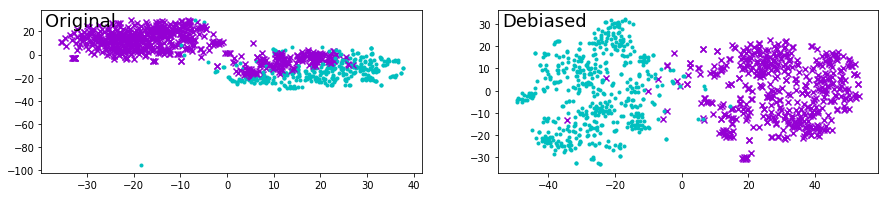

In [15]:
if debias_save_models:
    models = None
    models = load_fasttext(True)  #biggest bottleneck
    for model_info in models:
        res_weat = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory

13%|█▎        | 35193/264070 [00:00<00:00, 351918.59it/s]----------------Processing new model!------------------------------------------------------
NAME: cow-320
100%|██████████| 264070/264070 [00:00<00:00, 337897.72it/s]
size of vocabulary: 250969
Report bias by projection: 0.041460190506081004
PROJECTION STEP: COW-320_______UNRESTRICTED_________
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 1.0
ORIGINAL: Neighborhood Metric (closer to .5 is better) 1.0
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 1.0
DEBIASED: Neighborhood Metric (closer to .5 is better) 1.0
Cluster metric results: [orig,debiased]  [1.0, 1.0]
WEAT ORIGINAL STEP: COW-320_______UNRESTRICTED_________
WEAT DEBIASED STEP: COW-320_______UNRESTRICTED_________
LATEX:
(LONG WAIT)DOWNSTREAM STEP: COW-320_______UNRESTRICTED_________
  0%|          | 0/3110717 [00:00<?, ?it/s]Downstream biased: 0.5131982811540823
Downstream debiased: 0.5122774708410067
END of model: COW-320_______UNRESTRICTED___

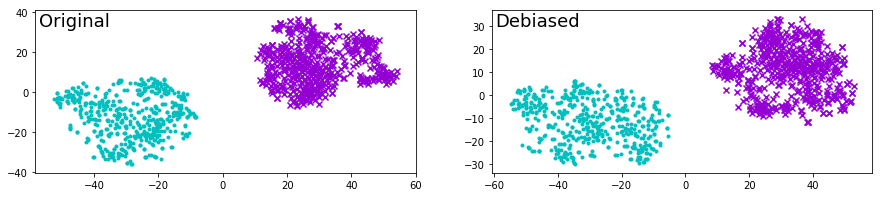

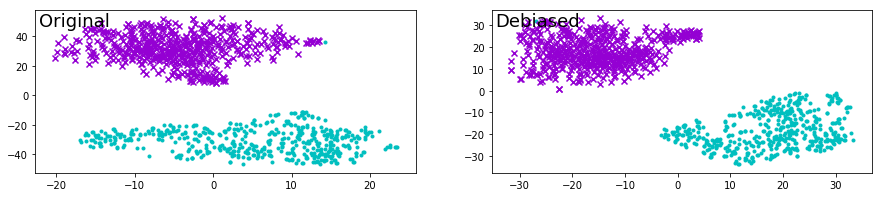

In [16]:
if debias_save_models:
    models = None
    models = load_cow(True)  #biggest bottleneck
    for model_info in models:
        res_weat = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory


6%|▌         | 34784/626710 [00:00<00:01, 347838.67it/s]----------------Processing new model!------------------------------------------------------
NAME: sonar-160
100%|██████████| 626710/626710 [00:01<00:00, 328224.27it/s]
size of vocabulary: 606659
Report bias by projection: 0.025899154700386777
PROJECTION STEP: SONAR-160_______UNRESTRICTED_________
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 0.998
ORIGINAL: Neighborhood Metric (closer to .5 is better) 0.998
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 0.998
DEBIASED: Neighborhood Metric (closer to .5 is better) 0.998
Cluster metric results: [orig,debiased]  [0.998, 0.998]
WEAT ORIGINAL STEP: SONAR-160_______UNRESTRICTED_________
WEAT DEBIASED STEP: SONAR-160_______UNRESTRICTED_________
LATEX:
(LONG WAIT)DOWNSTREAM STEP: SONAR-160_______UNRESTRICTED_________
  0%|          | 0/626710 [00:00<?, ?it/s]Downstream biased: 0.40838126540673786
Downstream debiased: 0.3944124897288414
END of model: SONAR-16

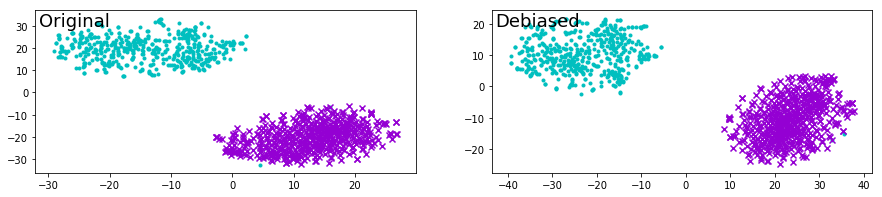

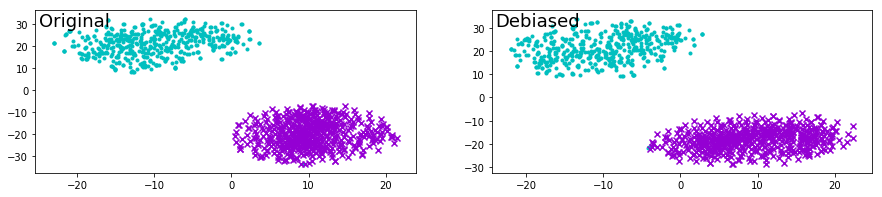

In [17]:
if debias_save_models:
    models = None
    models = load_sonar(True)  #biggest bottleneck
    for model_info in models:
        res_weat = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory

1%|▏         | 37141/2610657 [00:00<00:06, 371400.61it/s]----------------Processing new model!------------------------------------------------------
NAME: model_nlpl
100%|██████████| 2610657/2610657 [00:06<00:00, 376819.14it/s]
size of vocabulary: 1601208
Report bias by projection: 0.3592194025053485
PROJECTION STEP: MODEL_NLPL_______UNRESTRICTED_________
ORIGINAL: Model Results cluster_visualize
ORIGINAL: Precision 0.996
ORIGINAL: Neighborhood Metric (closer to .5 is better) 0.996
DEBIASED: Model Results cluster_visualize
DEBIASED: Precision 0.993
DEBIASED: Neighborhood Metric (closer to .5 is better) 0.993
Cluster metric results: [orig,debiased]  [0.996, 0.993]
WEAT ORIGINAL STEP: MODEL_NLPL_______UNRESTRICTED_________
WEAT DEBIASED STEP: MODEL_NLPL_______UNRESTRICTED_________
LATEX:
(LONG WAIT)DOWNSTREAM STEP: MODEL_NLPL_______UNRESTRICTED_________
Downstream biased: 0.43036946812829885
Downstream debiased: 0.4334145351197726
END of model: MODEL_NLPL_______UNRESTRICTED_________
RESU

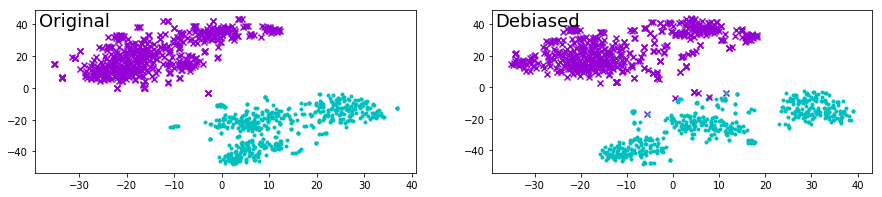

In [18]:
if debias_save_models:
    models = None
    models = load_nlpl(True)  #biggest bottleneck
    for model_info in models:
        res_weat = compute_all_tests(model_info['model'],model_info['vec_len'],model_info['name'], exclude_words, cluster_1817, downstream_1817, model_info['model_debiased'])
        print("RESULTS WEAT")
        print(res_weat)
        print("ACTUALLY END................................................................................")
        model_info = None #free memory

In [19]:
d_res_latex = util_r.create_latex_table_downstream(downstream_1817)
print(d_res_latex)
c_res_latex = util_r.create_latex_table_cluster(cluster_1817)
print(c_res_latex)

\begin{table}[htb!]
    \begin{center}

    \begin{tabular}{|c|c|c|}
    \hline 
        Model &  Original &  Debiased \\
       \hline
    fasttext_320_______unrestricted_________ & 0.6744525547445256 & 0.6623566214807091 \\
 \hline
 cow-320_______unrestricted_________ & 0.5131982811540823 & 0.5122774708410067 \\
 \hline
 cow-big_______unrestricted_________ & 0.515756087579292 & 0.5180069572334766 \\
 \hline
 sonar-160_______unrestricted_________ & 0.40838126540673786 & 0.3944124897288414 \\
 \hline
 sonar-320_______unrestricted_________ & 0.4294371405094495 & 0.4218364831552999 \\
 \hline
 model_nlpl_______unrestricted_________ & 0.43036946812829885 & 0.4334145351197726 \\
 \hline
  \end{tabular}
     \caption{Downstream task results, before and after debias step}

\label{tab2}
\end{center}
\end{table} 
\begin{table}[htb!]
    \begin{center}

    \begin{tabular}{|c|c|c|}
    \hline 
        Model &  Original &  Debiased \\
       \hline
    fasttext_320_______unrestricted_________ & 